<a href="https://colab.research.google.com/github/rraghu214/mnist_digit_recognition/blob/main/MNIST_Digits_Training_ERA_Iteration-5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CODE BLOCK: 1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [ ]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


CODE BLOCK: 3

In [ ]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [ ]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

CODE BLOCK: 5

In [ ]:
batch_size = 64

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}
kwargs_test = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs_test)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

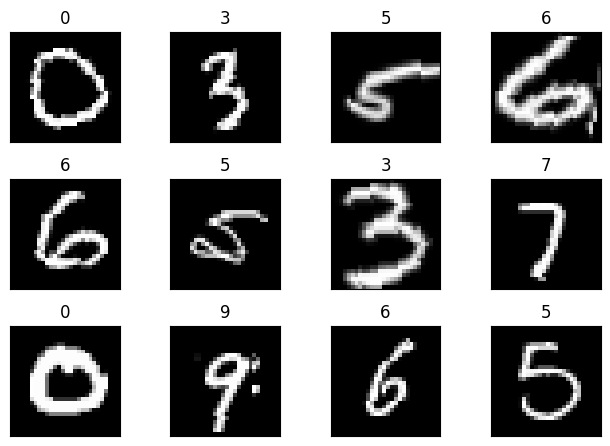

In [ ]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])



CODE BLOCK: 7

In [ ]:
class Net(nn.Module):
    def __init__(self):
        mypadding=1
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=mypadding)   # 1 → 16
        self.bn1 = nn.BatchNorm2d(8)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=mypadding)  # 16 → 32
        self.bn2 = nn.BatchNorm2d(16)
        self.conv1x1_1 = nn.Conv2d(16, 8, kernel_size=1)         # shrink channels

        self.conv3 = nn.Conv2d(8, 32, kernel_size=3, padding=mypadding)  # back to 32
        self.bn3 = nn.BatchNorm2d(16)

        self.conv1x1_2 = nn.Conv2d(32, 28, kernel_size=1)         # refine features

        # self.conv4 = nn.Conv2d(16, 32, kernel_size=3, padding=mypadding)  # back to 32
        # self.conv1x1_3 = nn.Conv2d(32, 32, kernel_size=1)         # refine features

        self.fc1 = nn.Linear(28*7*7, 10)  # after 2 poolings: 28→14→7

    def forward(self, x):
        # First block
        x = self.pool(F.relu(self.bn1(self.conv1(x))))   # [batch, 16, 14, 14]

        # Second block
        x = self.pool(F.relu(self.bn2(self.conv2(x))))   # [batch, 32, 7, 7]
        x = F.relu(self.conv1x1_1(x))          # [batch, 16, 7, 7]

        # Third block
        x = F.relu(self.conv3(x))              # [batch, 32, 7, 7]
        x = F.relu(self.conv1x1_2(x))          # [batch, 32, 7, 7]

        # # Fourth block
        # x = F.relu(self.conv4(x))              # [batch, 32, 7, 7]
        # x = F.relu(self.conv1x1_3(x))          # [batch, 32, 7, 7]

        # Flatten + FC
        x = torch.flatten(x, 1)                # [batch, 32*7*7]
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)



CODE BLOCK: 8

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [ ]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            # test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.002)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1 )
# New Line
# criterion = nn.CrossEntropyLoss(reduction='sum')
criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, train_loader, criterion)
  scheduler.step()

Epoch 1


Train: Loss=0.2157 Batch_id=937 Accuracy=93.55: 100%|██████████| 938/938 [00:23<00:00, 39.78it/s]


Test set: Average loss: 0.0013, Accuracy: 58470/60000 (97.45%)

Epoch 2


Train: Loss=0.0212 Batch_id=937 Accuracy=97.64: 100%|██████████| 938/938 [00:22<00:00, 40.80it/s]


Test set: Average loss: 0.0009, Accuracy: 58834/60000 (98.06%)

Epoch 3


Train: Loss=0.0330 Batch_id=937 Accuracy=98.10: 100%|██████████| 938/938 [00:24<00:00, 39.04it/s]


Test set: Average loss: 0.0008, Accuracy: 59060/60000 (98.43%)

Epoch 4


Train: Loss=0.0223 Batch_id=937 Accuracy=98.35: 100%|██████████| 938/938 [00:22<00:00, 41.63it/s]


Test set: Average loss: 0.0007, Accuracy: 59100/60000 (98.50%)

Epoch 5


Train: Loss=0.0942 Batch_id=937 Accuracy=98.40: 100%|██████████| 938/938 [00:23<00:00, 39.36it/s]


Test set: Average loss: 0.0006, Accuracy: 59330/60000 (98.88%)

Epoch 6


Train: Loss=0.0060 Batch_id=937 Accuracy=98.63: 100%|██████████| 938/938 [00:24<00:00, 39.05it/s]


Test set: Average loss: 0.0006, Accuracy: 59279/60000 (98.80%)

Epoch 7


Train: Loss=0.0042 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [00:22<00:00, 42.20it/s]


Test set: Average loss: 0.0006, Accuracy: 59226/60000 (98.71%)

Epoch 8


Train: Loss=0.0013 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:23<00:00, 40.11it/s]


Test set: Average loss: 0.0005, Accuracy: 59371/60000 (98.95%)

Epoch 9


Train: Loss=0.0046 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:23<00:00, 40.19it/s]


Test set: Average loss: 0.0005, Accuracy: 59382/60000 (98.97%)

Epoch 10


Train: Loss=0.0005 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [00:23<00:00, 40.15it/s]


Test set: Average loss: 0.0006, Accuracy: 59235/60000 (98.72%)

Epoch 11


Train: Loss=0.0109 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:22<00:00, 42.34it/s]


Test set: Average loss: 0.0005, Accuracy: 59417/60000 (99.03%)

Epoch 12


Train: Loss=0.0930 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [00:23<00:00, 40.26it/s]


Test set: Average loss: 0.0006, Accuracy: 59281/60000 (98.80%)

Epoch 13


Train: Loss=0.0359 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:23<00:00, 40.18it/s]


Test set: Average loss: 0.0005, Accuracy: 59344/60000 (98.91%)

Epoch 14


Train: Loss=0.0177 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [00:22<00:00, 41.67it/s]


Test set: Average loss: 0.0004, Accuracy: 59497/60000 (99.16%)

Epoch 15


Train: Loss=0.0248 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:23<00:00, 40.30it/s]


Test set: Average loss: 0.0004, Accuracy: 59497/60000 (99.16%)

Epoch 16


Train: Loss=0.0035 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:23<00:00, 40.52it/s]


Test set: Average loss: 0.0003, Accuracy: 59663/60000 (99.44%)

Epoch 17


Train: Loss=0.0003 Batch_id=937 Accuracy=99.43: 100%|██████████| 938/938 [00:23<00:00, 40.54it/s]


Test set: Average loss: 0.0003, Accuracy: 59708/60000 (99.51%)

Epoch 18


Train: Loss=0.0007 Batch_id=937 Accuracy=99.50: 100%|██████████| 938/938 [00:22<00:00, 42.56it/s]


Test set: Average loss: 0.0003, Accuracy: 59681/60000 (99.47%)

Epoch 19


Train: Loss=0.0003 Batch_id=937 Accuracy=99.47: 100%|██████████| 938/938 [00:22<00:00, 40.88it/s]


Test set: Average loss: 0.0002, Accuracy: 59731/60000 (99.55%)

Epoch 20


Train: Loss=0.0010 Batch_id=937 Accuracy=99.45: 100%|██████████| 938/938 [00:22<00:00, 40.85it/s]


Test set: Average loss: 0.0002, Accuracy: 59711/60000 (99.52%)



CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

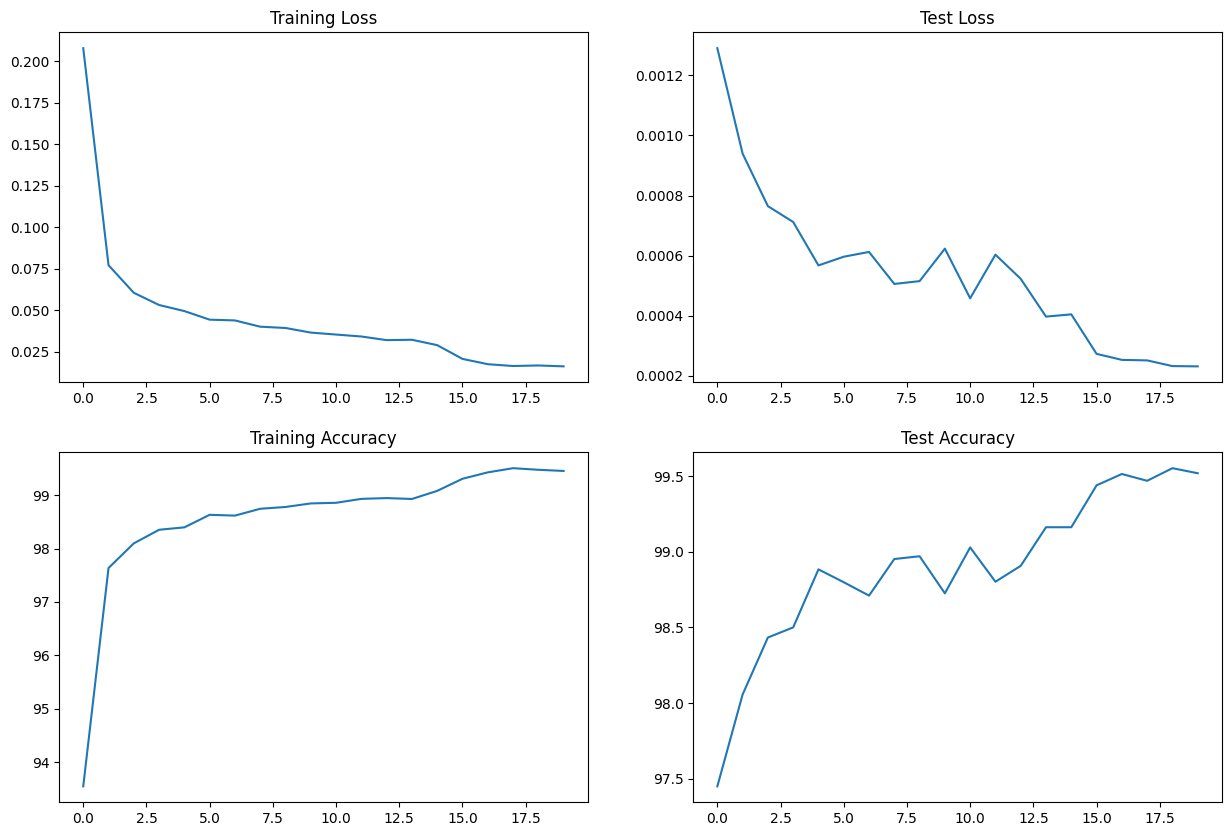

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           1,168
       BatchNorm2d-5           [-1, 16, 14, 14]              32
         MaxPool2d-6             [-1, 16, 7, 7]               0
            Conv2d-7              [-1, 8, 7, 7]             136
            Conv2d-8             [-1, 32, 7, 7]           2,336
            Conv2d-9             [-1, 28, 7, 7]             924
           Linear-10                   [-1, 10]          13,730
Total params: 18,422
Trainable params: 18,422
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.19
Params size (MB): 0.07
Estimated Tot